### VaMSL: Approximate inference of $p(G, \Theta, C,  \pi | D)$ for mixtures of (non)linear Gaussian Bayes nets

VaMSL carries out approximate inference over mixtures of Bayesian networks (BN) using coordinate ascent variational inference (CAVI). We instantiate the CAVI update over BNs with the Differentiable Bayesian Structure Learning (DiBS) ([Lorch et al., 2021](https://proceedings.neurips.cc/paper/2021/hash/ca6ab34959489659f8c3776aaf1f8efd-Abstract.html)) framework and it's Stein Variational gradient descent (SVGD) ([Liu and Wang, 2016](https://proceedings.neurips.cc/paper/2016/hash/b3ba8f1bee1238a2f37603d90b58898d-Abstract.html)) implementation.

DiBS leverages a generative model for graphs $p(G | Z)$ conditional on the continuous latent variable $Z$ to enable the use of gradient optimization methods in the (otherwise discrete) graph search accross BNs. Their SVGD implementation enables Bayesian structure learning by yielding a posterior in the BN space $p(G, \Theta | D)$.

In [1]:
%pip install ../. 
import jax
import jax.numpy as jnp
import jax.random as random

print(f"JAX backend: {jax.default_backend()}")
key=random.PRNGKey(123)

Processing /notebooks/VaMSL/VaMSL_proj
  Preparing metadata (setup.py) ... done
  Created wheel for vamsl-lib: filename=vamsl_lib-1.0-py3-none-any.whl size=51331 sha256=74e5e69d2b5ad47113a3e86dd6029b73a4c54905584cec254c59f6a3c4f9f7c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-fm41vzxe/wheels/c3/c1/d4/3d27c46fa93054064e8c77482810837b196d36b38802b832ca
Successfully built vamsl-lib
  Attempting uninstall: vamsl-lib
    Found existing installation: vamsl-lib 1.0
    Uninstalling vamsl-lib-1.0:
      Successfully uninstalled vamsl-lib-1.0
Note: you may need to restart the kernel to use updated packages.


I0000 00:00:1740488707.237439    1427 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


JAX backend: cpu


### Define the mixture model.

First we define the mixture of the observations as well as the component BNs in the mixture model. 

The elements of `mixing rate` defines the proportion of the total number of observations that are generated from each component. The entries should sum up to 1. The number of components `n_components` in the mixture model is taken to be the number indicated by the mixing rates, but can be set to a different value if so desired.

Each Gaussain BN has `n_vars` variables and has either a linear or nonlinear mean function depending on `struct_eq_type`. The nonlinear functions are modelled using shallow NNs. The random graph prior is either set to `er` (Erdos-Renyi) or `sf` (scale-free) graphs. 

In [46]:
# Set random seed
key = random.PRNGKey((seed:=523))

# Data settings
n_observations = 400 # total number of observations
mixing_rate = jnp.array([0.5,0.5]) # mixing rate of observations (also defines number of components)
#mixing_rate = 1/(K:=5) * jnp.ones(K) # uniform mixing rates for K components

# BN settings
n_vars = 20 # number of variables in each component BN
struct_eq_type = 'linear' # BN function class: 'linear' or 'nonlinear'
graph_type = 'sf' # Random graph structure: 'sf' (scale-free) or 'er' (Erdos-Renyi)

# Derived variables
n_components = mixing_rate.shape[0]
linear = True if struct_eq_type == 'linear' else False

### Generate ground truth BNs and synthetic data.

We generate synthetic data from ground truth BNs as specified above. `x_ind` is an observation array with {n_observations, n_vars+1}, where the last column consits of ground truth indicators for the corresponding ground truth BN. The varaibles `lik`, `component_lik`, and `graph_model` define likelihood models and the grpah prior model.

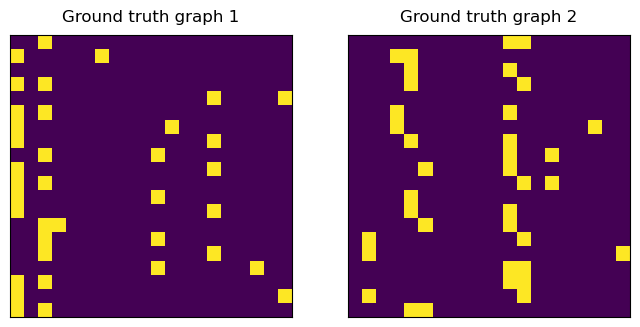

Observations shape:
x: (400, 20)
Indicators and counts:
(Array([0., 1.], dtype=float32), Array([200, 200], dtype=int32))


In [47]:
from vamsl.target import make_mixture_model
from vamsl.utils import visualize_ground_truth, visualize_ground_truths

key, subk = random.split(key)
# Generate data (with indicators for component assignment), ground truth BNs, likelihood models, and random graph model
x_ind, ground_truth_graphs, ground_truth_thetas, lik, component_lik, graph_model = make_mixture_model(key=subk,
                                                                                                      mixing_rate=mixing_rate,
                                                                                                      n_vars=n_vars,
                                                                                                      n_observations=n_observations,
                                                                                                      graph_type=graph_type,
                                                                                                      struct_eq_type=struct_eq_type)
visualize_ground_truths(ground_truth_graphs)
#print(ground_truth_graphs)
# Remove indicator vector from data
x = x_ind[:,0:n_vars] # [n_observations, n_vars]
print('Observations shape:')
print('x: ' + str(x.shape))
print('Indicators and counts:')
print(jnp.unique(x_ind[:,n_vars], return_counts=True))

In [48]:
import numpy as np
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

if  n_observations > 0:
    n_components = n_components
    random_state = seed

    labels = BayesianGaussianMixture(n_components=n_components, random_state=random_state, init_params='random_from_data', verbose=1).fit_predict(x)
    VGMM_assignments = confusion_matrix(x_ind[:,n_vars], labels)[:,linear_sum_assignment(confusion_matrix(x_ind[:,n_vars], labels), maximize=True)[1]]
    print("\nVGMM MAP clustering:\n", VGMM_assignments, '\n')
    print('Percentage missclassified: ', 100*jnp.sum(VGMM_assignments[~jnp.eye(n_components, dtype=bool)])/n_observations, '%') # mask diagonal with logical not of identity matrix

Initialization 0
Initialization converged: True

VGMM MAP clustering:
 [[200   0]
 [  0 200]] 

Percentage missclassified:  0.0 %


### Create VaMSL.

We create the VaMSL model and intilitialize it with `n_particles` randomly sampled particles latent $Z$ and $\Theta $ particles as well as uniform distributions over responsibilities and weights. If one wants to specify specific prior responsibilities and weights, they can be fed to `initialize_posteriors` as named variables `init_q_c` and `alphas`, of shapes `(n_observations, n_components)` and `(n_components,)` respectively. 

In [35]:
from vamsl.inference import VaMSL

# Create VaMSL and initialize posteriors (remove indicator vecor from dataset)
vamsl = VaMSL(x=x, graph_model=graph_model, mixture_likelihood_model=lik, component_likelihood_model=component_lik)
key, subk = random.split(key)
vamsl.initialize_posteriors(key=subk, n_components=n_components, n_particles=3, linear=linear)

print('Posterior shapes:')
posts = vamsl.get_posteriors()
print('q_z:     ' + str(posts[0].shape)) # [n_components, n_particls, d, l, 2]
print('q_theta: ' + str(posts[1].shape)) if linear else print('q_theta: ' + str(len(posts[1]))) # leading dim of n_components
print('log_q_c: ' + str(posts[2].shape)) # [n_observations, n_components]
print('q_pi:    ' + str(posts[3].shape)) # [n_components,]

Posterior shapes:
q_z:     (2, 3, 5, 5, 2)
q_theta: (2, 3, 5, 5)
log_q_c: (400, 2)
q_pi:    (2,)


In [37]:
#key, subk = random.split(key)
#_, false_graphs, _, _, _, _ = make_mixture_model(key=subk,mixing_rate=mixing_rate,n_vars=n_vars,n_observations=n_observations,graph_type=graph_type,struct_eq_type=struct_eq_type)

#E = jnp.ones((n_components, n_vars, n_vars)).at[i,j,...].set(1.0) # supply individual constraints 
E = jnp.where(ground_truth_graphs, 0.999, 0.001) # supply correct soft constraints 
#E = ground_truth_graphs # supply correct hard constraints

#print(false_graphs)
vamsl.set_E(E)
vamsl.get_E()
#vamsl.elicitation_probs_to_hard_constraints(vamsl.get_E()) # check hard constraints encoding
#vamsl.set_posteriors(q_z=vamsl.get_posteriors()[0], q_theta=jnp.array([[ground_truth_thetas[i] for j in range(7)] for i in range(n_components)]), log_q_c=vamsl.get_posteriors()[2], q_pi=1+jax.nn.one_hot(x_ind[:,n_vars], n_components).sum(axis=0))

Array([[[0.001, 0.001, 0.999, 0.001, 0.999],
        [0.001, 0.001, 0.999, 0.001, 0.999],
        [0.001, 0.001, 0.001, 0.001, 0.999],
        [0.001, 0.001, 0.999, 0.001, 0.999],
        [0.001, 0.001, 0.001, 0.001, 0.001]],

       [[0.001, 0.001, 0.001, 0.001, 0.001],
        [0.001, 0.001, 0.001, 0.999, 0.999],
        [0.999, 0.001, 0.001, 0.001, 0.999],
        [0.999, 0.001, 0.999, 0.001, 0.001],
        [0.999, 0.001, 0.001, 0.001, 0.001]]],      dtype=float32, weak_type=True)

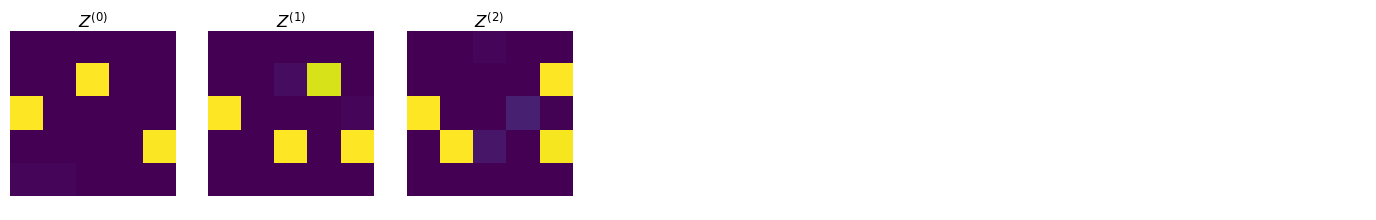

Component   1 | iteration 1000 | alpha   50.0 | beta 1000.0 | #cyclic   0


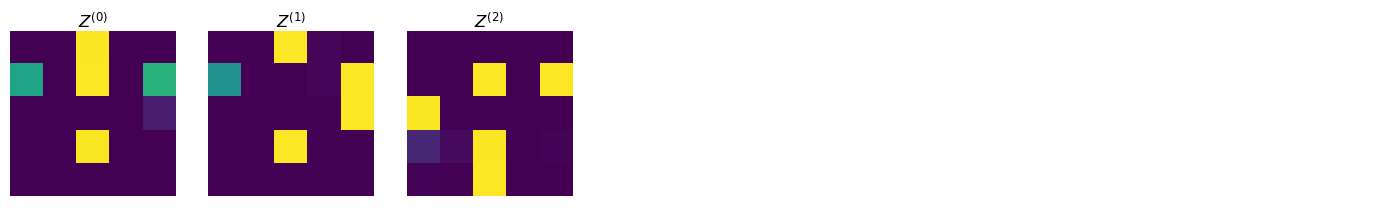

Component   2 | iteration 1000 | alpha   50.0 | beta 1000.0 | #cyclic   0


In [38]:
from sklearn.metrics import confusion_matrix

# CAVI and SVGD vars
n_cavi_updates, steps, callback_every = 10, 100, 100

# CAVI-loop
for cavi_update in range(n_cavi_updates):
    key, subk = random.split(key)
    # Optimize q(Z, \Theta)
    vamsl.update_particle_posteriors(key=subk, steps=steps, callback_every=callback_every,
                                     callback=vamsl.visualize_callback(save_path='./dibs_fit_pics/'), linear=linear)

    # Update to optimal q(c) and q(\pi)
    vamsl.update_responsibilities_and_weights()
    print(f'CAVI update number {cavi_update+1}/{n_cavi_updates}')
    
    # Print current clustering performance
    order = vamsl.identify_MAP_classification_ordering(ground_truth_indicator=x_ind[:,n_vars])
    y_pred = [order[k] for k in [jnp.argmax(c_i) for c_i in vamsl.get_posteriors()[2]]]
    print('MAP clustering: \n', confusion_matrix(x_ind[:,n_vars], y_pred))
    
# Final CAVI update with more SVGD steps to ensure annealing unto acyclic graphs
key, subk = random.split(key)
vamsl.update_particle_posteriors(key=subk, steps=1000, callback_every=200, callback=vamsl.visualize_callback(), linear=linear)
vamsl.update_responsibilities_and_weights()

### Get order of components with respect to ground truths

We identify an ordering of the components with respect to the ground truth BNs by identifying which perumutation of indeces results in the highest classification accuracy.

In [39]:
vamsl.update_responsibilities_and_weights()

In [40]:
# Compute optimal ordering with respect to MAP classification accuracy
order = vamsl.identify_MAP_classification_ordering(ground_truth_indicator=x_ind[:,n_vars])
print('Optimal order:')
print(order)

Optimal order:
[1 0]


### Evaluate classification performance

In [41]:
from sklearn.metrics import classification_report, confusion_matrix

print('Sums of responsibilities:')
print(jnp.sum(jnp.exp(vamsl.get_posteriors()[2]), axis=0))
print('Average entropy of responsibilities:')
print(jnp.sum(jnp.exp(vamsl.get_posteriors()[2])*vamsl.get_posteriors()[2])/vamsl.get_posteriors()[2].shape[0])
y_true = x_ind[:,n_vars]
y_pred = [order[k] for k in [jnp.argmax(c_i) for c_i in vamsl.get_posteriors()[2]]]
if n_components==2:
    print('Classification report:')
    print(classification_report(y_true=y_true, y_pred=y_pred, target_names=['Component 1', 'Component 2']))
print('Ordered confusion matrix:\n', (cm:=confusion_matrix(y_true, y_pred)))
print('Percentage missclassified: ', 100*jnp.sum(cm[~jnp.eye(n_components, dtype=bool)])/n_observations, '%') # mask diagonal with logical not of identity matrix

Sums of responsibilities:
[336.1689    63.831142]
Average entropy of responsibilities:
-0.054566175
Classification report:
              precision    recall  f1-score   support

 Component 1       1.00      0.29      0.46       200
 Component 2       0.59      1.00      0.74       200

    accuracy                           0.65       400
   macro avg       0.79      0.65      0.60       400
weighted avg       0.79      0.65      0.60       400

Ordered confusion matrix:
 [[ 59 141]
 [  0 200]]
Percentage missclassified:  35.25 %


In [42]:
from vamsl.metrics import expected_shd, threshold_metrics, neg_ave_log_likelihood

# Get component datasets
datas = [x_ind[x_ind[:,n_vars]==k][:,:n_vars] for k in range(n_components)]

# Loop over components and calculate metrics
for k, data, q_z_k, q_theta_k in zip(range(n_components), datas, vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
    # Get particle distribution for component
    q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[order[k]])
    dist = vamsl.get_empirical(q_g_k, q_theta_k)
    
    # Calculate metrics
    eshd = expected_shd(dist=dist, g=ground_truth_graphs[order[k]])       
    auroc = threshold_metrics(dist=dist, g=ground_truth_graphs[order[k]])['roc_auc']
    #negll = neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=data.x_ho)
    negll=0
    
    print(f' Component {k+1:4d} |  E-SHD: {eshd:4.1f}    AUROC: {auroc:5.2f}    neg. LL {negll:5.2f}')

 Component    1 |  E-SHD:  6.3    AUROC:  0.70    neg. LL  0.00
 Component    2 |  E-SHD:  4.0    AUROC:  0.81    neg. LL  0.00


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print('Sums of responsibilities:')
print(jnp.sum(jnp.exp(vamsl.get_posteriors()[2]), axis=0))
print('Average entropy of responsibilities:')
print(jnp.sum(jnp.exp(vamsl.get_posteriors()[2])*vamsl.get_posteriors()[2])/vamsl.get_posteriors()[2].shape[0])
y_true = x_ind[:,n_vars]
y_pred = [order[k] for k in [jnp.argmax(c_i) for c_i in vamsl.get_posteriors()[2]]]
if n_components==2:
    print('Classification report:')
    print(classification_report(y_true=y_true, y_pred=y_pred, target_names=['Component 1', 'Component 2']))
print('Ordered confusion matrix:\n', (cm:=confusion_matrix(y_true, y_pred)))
print('Percentage missclassified: ', 100*jnp.sum(cm[~jnp.eye(n_components, dtype=bool)])/n_observations, '%') # mask diagonal with logical not of identity matrix

### Evaluate structure learning performance

In [ ]:
from vamsl.metrics import expected_shd, threshold_metrics, neg_ave_log_likelihood

# Get component datasets
datas = [x_ind[x_ind[:,n_vars]==k][:,:n_vars] for k in range(n_components)]

# Loop over components and calculate metrics
for k, data, q_z_k, q_theta_k in zip(range(n_components), datas, vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
    # Get particle distribution for component
    q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[order[k]])
    dist = vamsl.get_empirical(q_g_k, q_theta_k)
    
    # Calculate metrics
    eshd = expected_shd(dist=dist, g=ground_truth_graphs[order[k]])       
    auroc = threshold_metrics(dist=dist, g=ground_truth_graphs[order[k]])['roc_auc']
    #negll = neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=data.x_ho)
    negll=0
    
    print(f' Component {k+1:4d} |  E-SHD: {eshd:4.1f}    AUROC: {auroc:5.2f}    neg. LL {negll:5.2f}')

In [ ]:
from vamsl.metrics import expected_shd, threshold_metrics, neg_ave_log_likelihood

# Get component datasets
datas = [x_ind[x_ind[:,n_vars]==k][:,:n_vars] for k in range(n_components)]

# Loop over components and calculate metrics
for k, data, q_z_k, q_theta_k in zip(range(n_components), datas, vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
    # Get particle distribution for component
    q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[order[k]])
    dist = vamsl.get_empirical(q_g_k, q_theta_k)
    
    # Calculate metrics
    eshd = expected_shd(dist=dist, g=ground_truth_graphs[order[k]])       
    auroc = threshold_metrics(dist=dist, g=ground_truth_graphs[order[k]])['roc_auc']
    #negll = neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=data.x_ho)
    negll=0
    
    print(f' Component {k+1:4d} |  E-SHD: {eshd:4.1f}    AUROC: {auroc:5.2f}    neg. LL {negll:5.2f}')

In [ ]:
from vamsl.metrics import expected_shd, threshold_metrics, neg_ave_log_likelihood

# Get component datasets
datas = [x_ind[x_ind[:,n_vars]==k][:,:n_vars] for k in range(n_components)]

# Loop over components and calculate metrics
for k, data, q_z_k, q_theta_k in zip(range(n_components), datas, vamsl.get_posteriors()[0], vamsl.get_posteriors()[1]):
    # Get particle distribution for component
    q_g_k = vamsl.particle_to_g_lim(q_z_k, vamsl.get_E()[order[k]])
    dist = vamsl.get_empirical(q_g_k, q_theta_k)
    
    # Calculate metrics
    eshd = expected_shd(dist=dist, g=ground_truth_graphs[order[k]])       
    auroc = threshold_metrics(dist=dist, g=ground_truth_graphs[order[k]])['roc_auc']
    #negll = neg_ave_log_likelihood(dist=dist, eltwise_log_likelihood=vamsl.eltwise_component_log_likelihood_observ, x=data.x_ho)
    negll=0
    
    print(f' Component {k+1:4d} |  E-SHD: {eshd:4.1f}    AUROC: {auroc:5.2f}    neg. LL {negll:5.2f}')

In [ ]:
vamsl.elicitation_probs_to_hard_constraints(vamsl.get_E())

### Elicitation

Incoporate elicited hard and soft edge constraints into VaMSL. Either provide an elicitation matrix, construct one by answering queries, or let a oracle simulate the process of querying an expert.

In [ ]:
from vamsl.elicitation.simulators import bernoulli_simulator
from vamsl.elicitation import edgeElicitation, graphOracle

init_queries = 0 
n_queries = 0 
random_queries=False
expert_reliability = 0

In [ ]:
E_1 = jnp.zeros((n_vars,n_vars)).at[0,1].set(1.0).at[0,2].set(1.0).at[2,1].set(1.0).at[1,0].set(-1.0).at[2,0].set(-1.0).at[1,2].set(-1.0)
E_2 = jnp.zeros((n_vars,n_vars)).at[1,0].set(1.0).at[2,0].set(1.0).at[3,0].set(1.0).at[0,1].set(-1.0).at[0,2].set(-1.0).at[0,3].set(-1.0)
visualize_ground_truth(E_1)
visualize_ground_truth(E_2)
#E_3 = jnp.zeros((n_vars,n_vars)).at[0,3].set(1.0).at[3,2].set(1.0).at[3,1].set(1.0)

E = jnp.stack([E_1, E_2], axis=0)
vamsl.set_E(E)

### Save model and data

In [ ]:
import pickle
#filename = '5_d_14_p_100_s_30_e_2000_s.p'
pickle.dump(vamsl.get_posteriors(), open(filename, 'wb'))

In [ ]:
import pickle
posts = pickle.load(open('20_d_14_p_200_s_20_e_2000_s.p', 'rb'))

In [1]:
import jax
import jax.numpy as jnp
import jax.random as random

print(f"JAX backend: {jax.default_backend()}")
key=random.PRNGKey(123)

I0000 00:00:1740485902.454452     302 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


JAX backend: cpu


In [11]:
log_q_c = jnp.log(1/3*jnp.ones((10,3)))
log_q_c = jnp.log(jnp.hstack([jnp.ones((10,1)),jnp.zeros((10,2))]))

print(log_q_c.shape)

mc_samples = 5

key=random.PRNGKey(123)
# Sample assignments from categorical distribution parametrized by responsibilities
assignments = random.categorical(key=key, logits=log_q_c, shape=(mc_samples, log_q_c.shape[0]))
print(assignments.shape)
# Construct matrix of one-hot vectors from sampled assignmnets
one_hot_assignments = jax.nn.one_hot(assignments, num_classes=log_q_c.shape[1])
print(one_hot_assignments.shape)

jnp.array([one_hot_assignments[...,col] for col in range(log_q_c.shape[1])]).shape
        

(10, 3)
(5, 10)
(5, 10, 3)


(3, 5, 10)